In [56]:
import sklearn
print(sklearn.__version__)

1.3.2


In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

#### 

#### Importando a base de dados feita com o script de coleta de dados a partir do Yahoofinance, atualmente para não pesar temos apenas 3 ativos. Mas podemos fazer todos ativos da bolsa disponível quando desejar.

In [2]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


#### Ordenando por data e ticker e pegando a diferença do dia anterior.

In [3]:
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by = ['Ticker','Date'], inplace = True)

price_data['change_in_price'] = price_data['Close'].diff()
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999


In [4]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    return np.sign(data.shift(-d) - data)



# Aplicando a suavização exponencial
alpha = 0.20
price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)


d = 45
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA,-0.026404,0.515601,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA,-0.013185,0.508740,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA,0.003296,0.503909,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA,0.009889,0.502023,1.0


In [5]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target_verify(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1  # Substitui os 0 por -1
    return target



# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)

# Calculando o target para d = 10 dias
d = 45
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,1.0,0.520882,1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA,-0.026404,0.515601,1.0,0.494478,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA,-0.013185,0.508740,1.0,0.481293,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA,0.003296,0.503909,1.0,0.484589,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA,0.009889,0.502023,1.0,0.494478,1.0


In [7]:

price_data['Close_45'] = price_data.groupby('Ticker')['Close'].shift(-45)
price_data['Smoothed_Close_45'] = price_data.groupby('Ticker')['Smoothed_Close'].shift(-45)

#### Tirando a diferença do 'Smoothed_Close' na virada de um tick para outro.

In [8]:
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)

price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

price_data[price_data.isna().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,Close_45,Smoothed_Close_45
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,1.0,0.520882,1.0,0.599993,0.574836,0.599993,0.605143
5706,2024-11-19,12.450000,12.600000,12.420000,12.430000,12.191905,28564100,ABEV3.SA,0.010000,12.549591,NaN,12.430000,NaN,11.540000,11.827934,NaN,NaN
5707,2024-11-21,12.310000,12.480000,12.300000,12.390000,12.152671,18400700,ABEV3.SA,-0.040000,12.517673,NaN,12.390000,NaN,11.420000,11.746347,NaN,NaN
5708,2024-11-22,12.490000,12.700000,12.470000,12.680000,12.437116,24116600,ABEV3.SA,0.290000,12.550138,NaN,12.680000,NaN,11.400000,11.677078,NaN,NaN
5709,2024-11-25,12.590000,12.690000,12.540000,12.540000,12.299797,22015800,ABEV3.SA,-0.140000,12.548111,NaN,12.540000,NaN,11.160000,11.573662,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,NaN,NaN
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,NaN,NaN
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,NaN,NaN
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,NaN,NaN


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [9]:
# Período do indicador.
n = 17

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,Close_45,Smoothed_Close_45,down_days,up_days,RSI
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,NaN,NaN,0.270000,0.000000,55.853147
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,NaN,NaN,1.360001,0.000000,42.289035
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,NaN,NaN,0.340000,0.000000,39.585265
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,NaN,NaN,0.000000,0.709999,47.474635
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,NaN,NaN,0.119999,0.000000,46.324413


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [10]:
t = 14
low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))

price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,Close_45,Smoothed_Close_45,down_days,up_days,RSI,low_14,high_14,k_percent_14
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,NaN,NaN,0.270000,0.000000,55.853147,50.869999,55.099998,57.575879
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,NaN,NaN,1.360001,0.000000,42.289035,50.869999,54.490002,63.711767
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,NaN,NaN,0.340000,0.000000,39.585265,50.869999,54.490002,58.980461
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,NaN,NaN,0.000000,0.709999,47.474635,50.869999,54.490002,59.118061
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,NaN,NaN,0.119999,0.000000,46.324413,50.869999,54.490002,58.565163


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [11]:
# Período de cálculo do indicador
t = 14

low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()

#Aplicanod a função no grupo
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)

price_data[f'r_percent_{t}'] = r_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,Close_45,Smoothed_Close_45,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,NaN,NaN,0.270000,0.000000,55.853147,50.869999,55.099998,57.575879,-42.424121
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,NaN,NaN,1.360001,0.000000,42.289035,50.869999,54.490002,63.711767,-36.288233
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,NaN,NaN,0.340000,0.000000,39.585265,50.869999,54.490002,58.980461,-41.019539
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,NaN,NaN,0.000000,0.709999,47.474635,50.869999,54.490002,59.118061,-40.881939
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,NaN,NaN,0.119999,0.000000,46.324413,50.869999,54.490002,58.565163,-41.434837


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [12]:
# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,Close_45,Smoothed_Close_45,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,NaN,NaN,0.270000,0.000000,55.853147,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,NaN,NaN,1.360001,0.000000,42.289035,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,NaN,NaN,0.340000,0.000000,39.585265,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,NaN,NaN,0.000000,0.709999,47.474635,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,NaN,NaN,0.119999,0.000000,46.324413,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [13]:
# Período do indicador
e = 27

# Calculando o Price Rate
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,Close_45,Smoothed_Close_45,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,NaN,NaN,0.270000,0.000000,55.853147,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394,-0.084526
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,NaN,NaN,1.360001,0.000000,42.289035,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933,-0.091557
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,NaN,NaN,0.340000,0.000000,39.585265,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366,-0.095423
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,NaN,NaN,0.000000,0.709999,47.474635,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930,-0.089475
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,NaN,NaN,0.119999,0.000000,46.324413,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109,-0.082382


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [14]:
def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)
        

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)

price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,Close_45,Smoothed_Close_45,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,NaN,NaN,0.270000,0.000000,55.853147,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394,-0.084526,2329297670
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,NaN,NaN,1.360001,0.000000,42.289035,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933,-0.091557,2294652270
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,NaN,NaN,0.340000,0.000000,39.585265,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366,-0.095423,2269554970
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,NaN,NaN,0.000000,0.709999,47.474635,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930,-0.089475,2290075570
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,NaN,NaN,0.119999,0.000000,46.324413,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109,-0.082382,2288822970


#### Salvando antes de tirar os Nans.

In [15]:
price_data.to_parquet('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.parquet', index=False)

In [16]:
# price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.xlsx', index=False)

## Removendo Nans

In [17]:
# We need to remove all rows that have an NaN value.
print('Antes de tirar as NaN nós tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('Depois da retirada dos NaN temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.tail()

Antes de tirar as NaN nós tinhamos 27044 linhas e 28 colunas
Depois da retirada dos NaN temos 26684 linhas e 28 colunas


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,Close_45,Smoothed_Close_45,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11734,2024-11-11,59.750000,59.869999,58.650002,58.650002,58.131153,24483700,VALE3.SA,-1.980000,61.254148,-1.0,58.650002,-1.0,54.740002,55.332221,54.020000,53.305458,1.980000,0.000000,34.686566,58.650002,63.990002,48.766795,-51.233205,0.318598,0.382283,-0.017949,2569015870
11735,2024-11-12,58.580002,58.590000,57.200001,57.320000,56.812916,26967600,VALE3.SA,-1.330002,60.467319,-1.0,57.320000,-1.0,54.549999,55.175777,52.660000,53.176367,1.330002,0.000000,30.235106,57.200001,63.990002,48.119551,-51.880449,0.198989,0.345624,-0.030894,2542048270
11736,2024-11-13,57.320000,57.720001,57.110001,57.160000,56.654331,20354900,VALE3.SA,-0.160000,59.805855,-1.0,57.160000,-1.0,54.250000,54.990622,52.320000,53.005093,0.160000,0.000000,29.718934,57.110001,63.990002,39.183923,-60.816077,0.050244,0.286548,-0.043442,2521693370
11737,2024-11-14,57.160000,57.340000,56.840000,56.840000,56.337162,17967600,VALE3.SA,-0.320000,59.212684,-1.0,56.840000,-1.0,53.240002,54.640498,53.029999,53.010074,0.320000,0.000000,28.619602,56.840000,63.990002,33.184382,-66.815618,-0.114185,0.206402,-0.048663,2503725770
11738,2024-11-18,57.090000,57.779999,56.970001,57.549999,57.040882,14300000,VALE3.SA,0.709999,58.880147,-1.0,57.549999,-1.0,52.560001,54.224398,52.910000,52.990059,0.000000,0.709999,34.653256,56.840000,63.990002,28.533517,-71.466483,-0.268237,0.111474,-0.050094,2489425770


## VALIDAÇÃO

### Geral

In [18]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI', f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 310, oob_score = True, criterion = "gini", random_state = 0, n_jobs=-1)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  76.300404736921


In [19]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction'
price_data['Prediction'] = rand_frst_clf.predict(X_Cols)

# Comparar valores e calcular a precisão
price_data['Match'] = (price_data['Prediction'] == price_data['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = price_data['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 86.54%


In [53]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl']

### AMBEV

#### Time Series Cross-Validation.

In [24]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data_ABEV.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,Close_45,Smoothed_Close_45,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
5701,2024-11-11,12.31,12.55,12.26,12.51,12.270372,20684800,ABEV3.SA,0.180000,12.586564,-1.0,12.51,-1.0,12.07,12.554056,11.25,11.256312,0.000000,0.18,39.942916,12.26,13.09,39.345088,-60.654912,-0.081478,-0.033515,-0.021861,-2321489347,1
5702,2024-11-12,12.43,12.64,12.30,12.58,12.339031,26899600,ABEV3.SA,0.070000,12.585252,-1.0,12.58,-1.0,11.74,12.391245,11.02,11.209050,0.000000,0.07,44.092382,12.26,13.09,39.186907,-60.813093,-0.089866,-0.044785,-0.025177,-2348388947,1
5703,2024-11-13,12.52,12.77,12.46,12.73,12.486157,30341700,ABEV3.SA,0.150000,12.614201,-1.0,12.73,-1.0,11.60,12.232996,11.05,11.177240,0.000000,0.15,52.074863,12.26,13.09,42.674811,-57.325189,-0.093104,-0.054449,-0.033264,-2318047247,1
5704,2024-11-14,12.69,12.90,12.61,12.64,12.397882,38027500,ABEV3.SA,-0.089999,12.619361,-1.0,12.64,-1.0,11.33,12.052397,10.87,11.115792,0.089999,0.00,47.497276,12.26,13.09,43.296479,-56.703521,-0.094169,-0.062393,-0.042725,-2280019747,1
5705,2024-11-18,12.48,12.67,12.38,12.42,12.182096,37251000,ABEV3.SA,-0.220000,12.579489,-1.0,12.42,-1.0,11.29,11.899917,10.91,11.074633,0.220000,0.00,38.250631,12.26,13.09,38.492602,-61.507398,-0.097111,-0.069337,-0.048887,-2317270747,1


In [25]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=310, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")



Fold 1:
  Accuracy with Y_test (Prediction): 0.5074
  Accuracy with Verify: 0.4979
Fold 2:
  Accuracy with Y_test (Prediction): 0.4905
  Accuracy with Verify: 0.4831
Fold 3:
  Accuracy with Y_test (Prediction): 0.6047
  Accuracy with Verify: 0.5803
Fold 4:
  Accuracy with Y_test (Prediction): 0.6131
  Accuracy with Verify: 0.5983
Fold 5:
  Accuracy with Y_test (Prediction): 0.5666
  Accuracy with Verify: 0.4947

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5564
  Média da acurácia com Verify: 0.5309


#### Walk-Forward Validation

In [26]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]


In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=310, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_ABEV) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Ambev.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.4056
  Accuracy with Verify: 0.3111
Window 2:
  Accuracy with Y_test (Prediction): 0.1167
  Accuracy with Verify: 0.0944
Window 3:
  Accuracy with Y_test (Prediction): 0.7778
  Accuracy with Verify: 0.7167
Window 4:
  Accuracy with Y_test (Prediction): 0.6611
  Accuracy with Verify: 0.6833
Window 5:
  Accuracy with Y_test (Prediction): 0.3722
  Accuracy with Verify: 0.4278
Window 6:
  Accuracy with Y_test (Prediction): 0.9111
  Accuracy with Verify: 0.9167
Window 7:
  Accuracy with Y_test (Prediction): 0.3722
  Accuracy with Verify: 0.2889
Window 8:
  Accuracy with Y_test (Prediction): 0.6556
  Accuracy with Verify: 0.6389
Window 9:
  Accuracy with Y_test (Prediction): 0.2889
  Accuracy with Verify: 0.3111
Window 10:
  Accuracy with Y_test (Prediction): 0.5278
  Accuracy with Verify: 0.4722
Window 11:
  Accuracy with Y_test (Prediction): 0.3444
  Accuracy with Verify: 0.3500
Window 12:
  Accuracy with Y_test (Prediction): 0.5111
  Accura

#### Split normal sem cross-validation.

In [28]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

In [29]:
# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators = 310, oob_score = True, criterion = "gini", random_state = 0, max_depth= None, max_samples=None, max_leaf_nodes=None,n_jobs=-1)

# Fit the data to the model
rand_frst_clf_Ambev.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Ambev.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Ambev.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  83.94366197183099


In [30]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.837004,0.711610,0.769231,534.000000
Up Day,0.840580,0.916479,0.876890,886.000000
accuracy,0.839437,0.839437,0.839437,0.839437
macro avg,0.838792,0.814045,0.823060,1420.000000
weighted avg,0.839235,0.839437,0.836404,1420.000000


Accuracy: 0.8394366197183099
Precision: 0.8405797101449275
Recall: 0.9164785553047404
Specificity: 0.7116104868913857
F1-Score: 0.8769


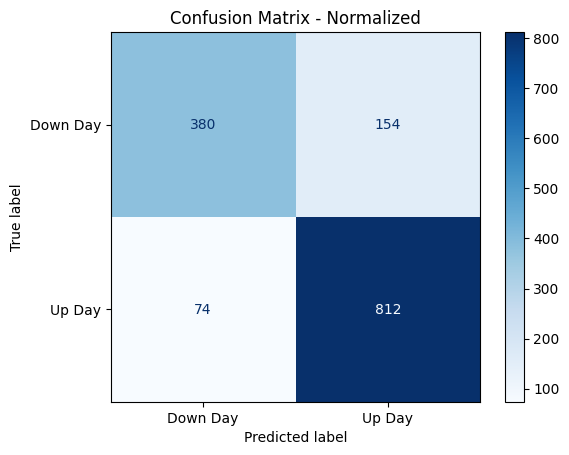

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


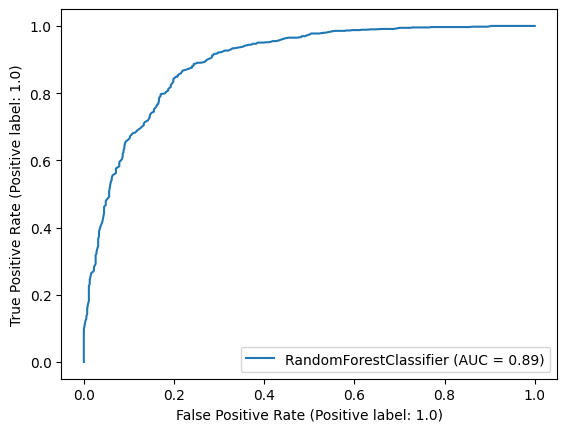

In [32]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para AMBEV.

In [84]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Ambev, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl']

#### Carregar modelo. Geralmente carrego do modelo aprendido geral.

In [ ]:
# Carregar o modelo salvo
rand_frst_clf_Ambev = joblib.load('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

#### Utilizando a verificação da predicação com o preço real e não suavizado.

In [33]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_ABEV['Prediction'] = np.NaN  # Inicializando a coluna
price_data_ABEV['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_ABEV['Match'] = (price_data_ABEV['Prediction'] == price_data_ABEV['Verify']).astype(int)
overall_accuracy = price_data_ABEV['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_ABEV[price_data_ABEV['Date'] >= price_data_ABEV['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 83.73%

Precisão do modelo nos últimos 30 dias: 100.00%


#### Plotagem:

In [38]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

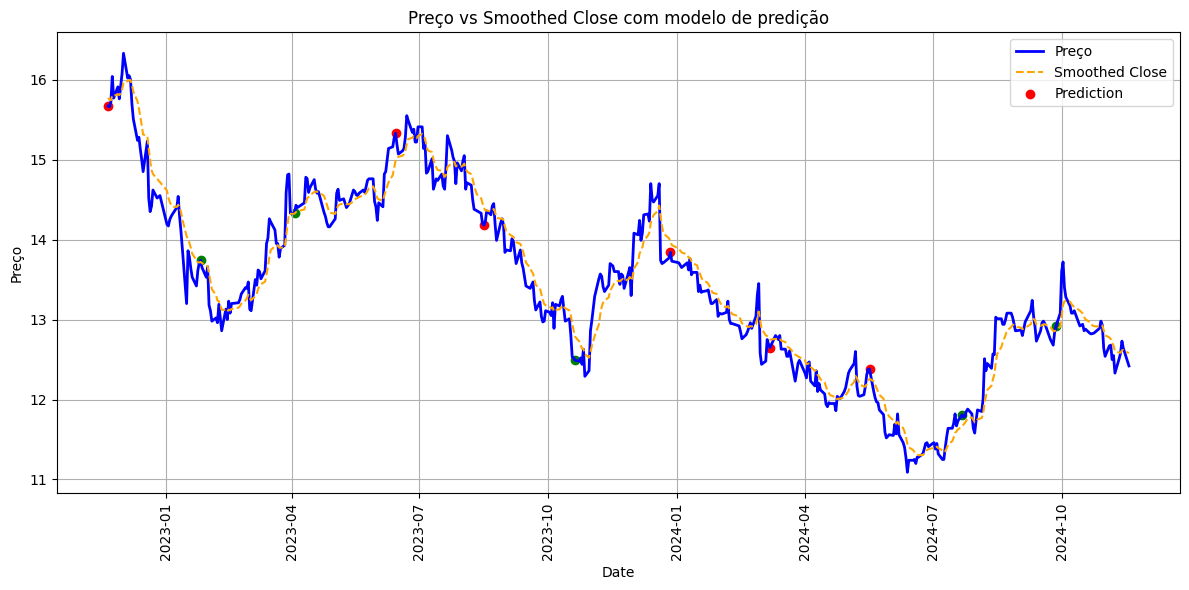

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ABEV3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=730)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=310, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 45):
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### ITAÚ

#### Time series Cross-Validation

In [40]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data_Itau.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,Close_45,Smoothed_Close_45,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
17892,2001-02-02,3.030096,3.046653,2.988701,3.046653,1.747820,33832788,ITUB4.SA,0.016557,3.099264,-1.0,3.046653,-1.0,2.732053,2.764207,2.806564,2.756096,0.000000,0.016557,42.201788,2.988701,3.377811,28.414302,-71.585698,0.019829,0.025947,0.046853,544308870,1
17893,2001-02-05,3.030096,3.030096,2.963864,2.972143,1.705074,11958036,ITUB4.SA,-0.074510,3.073840,-1.0,2.972143,-1.0,2.781727,2.767711,2.798616,2.764600,0.074510,0.000000,35.349516,2.963864,3.377811,26.567579,-73.432421,0.014318,0.023621,0.047345,532350834,1
17894,2001-02-06,2.996980,3.005259,2.980422,3.005259,1.724071,36043213,ITUB4.SA,0.033116,3.060124,-1.0,3.005259,-1.0,2.632706,2.740710,2.897632,2.791206,0.000000,0.033116,40.204097,2.963864,3.377811,23.254076,-76.745924,0.008854,0.020668,0.050077,496307621,1
17895,2001-02-07,2.996814,2.996814,2.930748,2.947306,1.690827,61444982,ITUB4.SA,-0.057953,3.037560,-1.0,2.947306,-1.0,2.748611,2.742290,2.831401,2.799245,0.057953,0.000000,35.026099,2.930748,3.377811,23.891955,-76.108045,0.002833,0.017101,0.041387,434862639,1
17896,2001-02-08,2.978766,3.071490,2.978766,3.029764,1.738130,54137293,ITUB4.SA,0.082458,3.036001,-1.0,3.029764,-1.0,2.856238,2.765080,2.782555,2.795907,0.000000,0.082458,46.131517,2.930748,3.377811,23.543184,-76.456816,-0.002019,0.013277,0.030510,380725346,1


In [41]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=310 , oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.5686
  Accuracy with Verify: 0.5457
Fold 2:
  Accuracy with Y_test (Prediction): 0.5156
  Accuracy with Verify: 0.5260
Fold 3:
  Accuracy with Y_test (Prediction): 0.5655
  Accuracy with Verify: 0.5437
Fold 4:
  Accuracy with Y_test (Prediction): 0.5936
  Accuracy with Verify: 0.5863
Fold 5:
  Accuracy with Y_test (Prediction): 0.6913
  Accuracy with Verify: 0.6486

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5869
  Média da acurácia com Verify: 0.5701

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0             -1.0    -1.0
2            1.0             -1.0    -1.0
3            1.0             -1.0    -1.0
4            1.0             -1.0    -1.0
...          ...              ...     ...
4805        -1.0             -1.0    -1.0
4806        -1.0             -1.0    -1.0
4807        -1.0             -1.0    -1.0
4808        -1.0             -1.0    -

#### Walk-Forward Validation

In [42]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

In [43]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=310, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Itau) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Itau.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.4222
  Accuracy with Verify: 0.3667
Window 2:
  Accuracy with Y_test (Prediction): 0.1778
  Accuracy with Verify: 0.1833
Window 3:
  Accuracy with Y_test (Prediction): 0.4278
  Accuracy with Verify: 0.4722
Window 4:
  Accuracy with Y_test (Prediction): 0.6111
  Accuracy with Verify: 0.6000
Window 5:
  Accuracy with Y_test (Prediction): 0.6889
  Accuracy with Verify: 0.6778
Window 6:
  Accuracy with Y_test (Prediction): 0.6778
  Accuracy with Verify: 0.6000
Window 7:
  Accuracy with Y_test (Prediction): 0.4889
  Accuracy with Verify: 0.4722
Window 8:
  Accuracy with Y_test (Prediction): 0.5111
  Accuracy with Verify: 0.4444
Window 9:
  Accuracy with Y_test (Prediction): 0.5778
  Accuracy with Verify: 0.4944
Window 10:
  Accuracy with Y_test (Prediction): 0.2833
  Accuracy with Verify: 0.2611
Window 11:
  Accuracy with Y_test (Prediction): 0.6556
  Accuracy with Verify: 0.6611
Window 12:
  Accuracy with Y_test (Prediction): 0.4111
  Accura

#### Split normal sem cross-validation.

In [44]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

In [45]:
# Grab our X & Y Columns.
X_Cols = price_data_Itau[['RSI',f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators = 310, oob_score = True, criterion = "gini", random_state = 0,n_jobs=-1)

# Fit the data to the model
rand_frst_clf_Itau.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Itau.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Itau.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  83.17174515235457


In [46]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.808264,0.793831,0.800983,616.000000
Up Day,0.848629,0.859903,0.854229,828.000000
accuracy,0.831717,0.831717,0.831717,0.831717
macro avg,0.828447,0.826867,0.827606,1444.000000
weighted avg,0.831410,0.831717,0.831515,1444.000000


Accuracy: 0.8317174515235457
Precision: 0.8486293206197855
Recall: 0.8599033816425121
Specificity: 0.7938311688311688
F1-Score: 0.8542


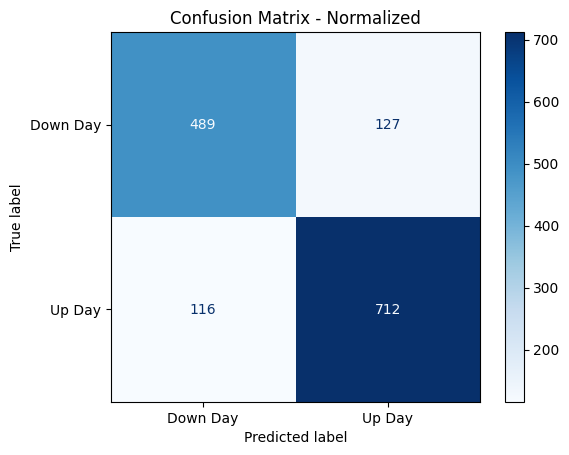

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)


# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


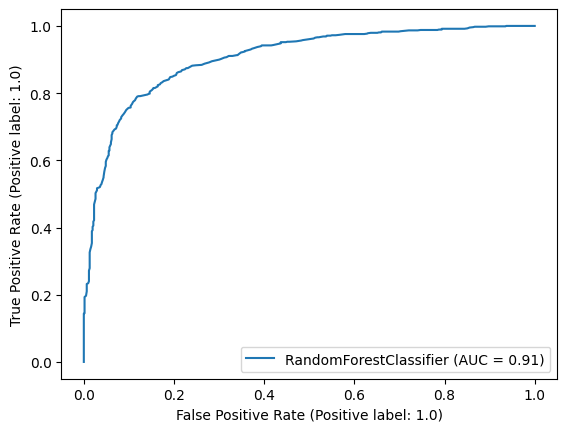

In [48]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Itau, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para ITAU.

In [247]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Itau, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [49]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Itau['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Itau['Prediction'] = rand_frst_clf_Itau.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Itau['Match'] = (price_data_Itau['Prediction'] == price_data_Itau['Verify']).astype(int)
overall_accuracy = price_data_Itau['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Itau[price_data_Itau['Date'] >= price_data_Itau['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Itau.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 84.29%

Precisão do modelo nos últimos 30 dias: 100.00%


#### Plotagem:

In [50]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

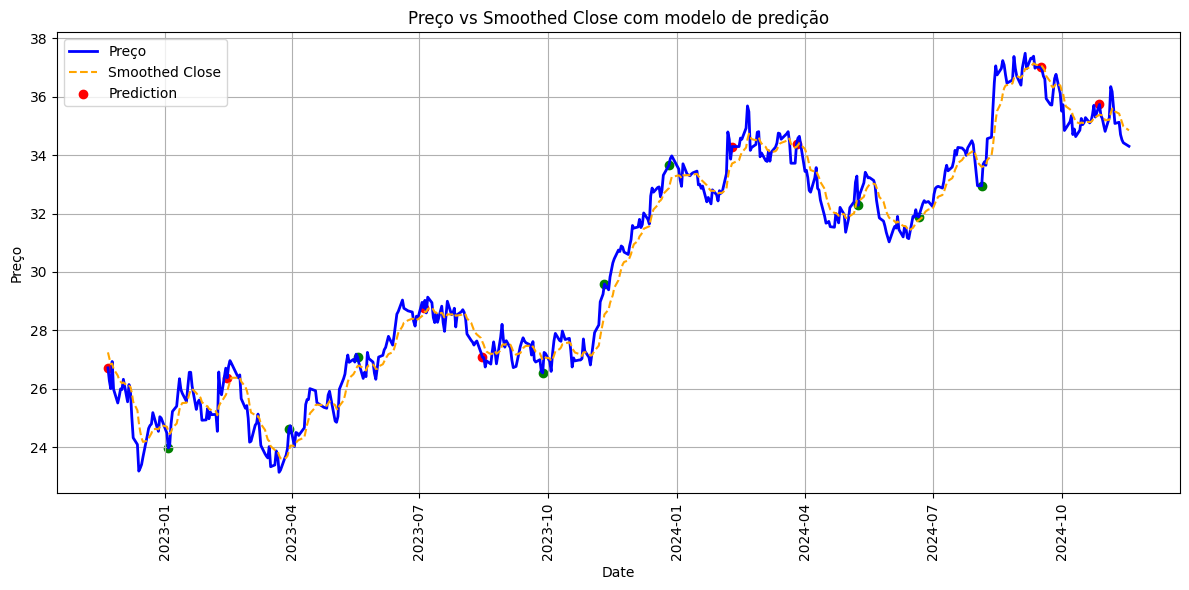

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ITUB4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=730)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=310, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 30):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### MAGALU

#### Time series Cross-Validation

In [52]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data_Magalu.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,Close_45,Smoothed_Close_45,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
23739,2011-06-10,4.954290,5.012748,4.857835,5.012748,4.616810,1587130,MGLU3.SA,0.014614,4.869749,1.0,5.012748,-1.0,4.246952,4.326911,3.910820,3.709381,0.000000,0.014614,75.563706,4.436940,5.047823,70.849779,-29.150221,0.019998,-0.002269,0.012812,-3394128,0
23740,2011-06-13,5.012748,5.191044,4.998134,5.056591,4.657189,2819132,MGLU3.SA,0.043843,4.907118,-1.0,5.056591,-1.0,4.512935,4.364116,3.840671,3.735639,0.000000,0.043843,77.977952,4.436940,5.191044,62.349178,-37.650822,0.029169,0.004018,0.022449,-574996,1
23741,2011-06-14,5.085820,5.129663,4.872450,5.003979,4.608733,2110243,MGLU3.SA,-0.052612,4.926490,-1.0,5.003979,-1.0,4.366790,4.364651,3.864054,3.761322,0.052612,0.000000,68.801458,4.436940,5.191044,64.918098,-35.081902,0.037397,0.010694,0.025736,1535247,1
23742,2011-06-15,4.998134,4.998134,4.887064,4.936753,4.546816,1644265,MGLU3.SA,-0.067226,4.928543,-1.0,4.936753,-1.0,4.135882,4.318897,3.878668,3.784791,0.067226,0.000000,58.846593,4.536318,5.191044,59.906690,-40.093310,0.043539,0.017263,0.026813,3179512,1
23743,2011-06-16,4.822760,4.930907,4.673693,4.910447,4.522589,2052423,MGLU3.SA,-0.026306,4.924923,-1.0,4.910447,-1.0,4.018967,4.258911,3.752984,3.778430,0.026306,0.000000,55.322849,4.559701,5.191044,57.848513,-42.151487,0.047569,0.023324,0.028082,1127089,1


In [53]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=310, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.6041
  Accuracy with Verify: 0.6022
Fold 2:
  Accuracy with Y_test (Prediction): 0.3628
  Accuracy with Verify: 0.3610
Fold 3:
  Accuracy with Y_test (Prediction): 0.5893
  Accuracy with Verify: 0.5838
Fold 4:
  Accuracy with Y_test (Prediction): 0.4291
  Accuracy with Verify: 0.4457
Fold 5:
  Accuracy with Y_test (Prediction): 0.4125
  Accuracy with Verify: 0.2928

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.4796
  Média da acurácia com Verify: 0.4571

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2            1.0              1.0     1.0
3            1.0              1.0     1.0
4            1.0              1.0     1.0
...          ...              ...     ...
2710         1.0              1.0    -1.0
2711         1.0             -1.0    -1.0
2712         1.0              1.0    -1.0
2713         1.0             -1.0    -

#### Walk-Forward Validation

In [54]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

In [55]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=310, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Magalu) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Magalu.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.5778
  Accuracy with Verify: 0.5667
Window 2:
  Accuracy with Y_test (Prediction): 0.6111
  Accuracy with Verify: 0.5889
Window 3:
  Accuracy with Y_test (Prediction): 0.8611
  Accuracy with Verify: 0.8167
Window 4:
  Accuracy with Y_test (Prediction): 0.5667
  Accuracy with Verify: 0.5611
Window 5:
  Accuracy with Y_test (Prediction): 0.5333
  Accuracy with Verify: 0.5333
Window 6:
  Accuracy with Y_test (Prediction): 0.9944
  Accuracy with Verify: 1.0000
Window 7:
  Accuracy with Y_test (Prediction): 0.8222
  Accuracy with Verify: 0.8222
Window 8:
  Accuracy with Y_test (Prediction): 0.7111
  Accuracy with Verify: 0.7222
Window 9:
  Accuracy with Y_test (Prediction): 0.7778
  Accuracy with Verify: 0.7833
Window 10:
  Accuracy with Y_test (Prediction): 0.7167
  Accuracy with Verify: 0.7500
Window 11:
  Accuracy with Y_test (Prediction): 0.6333
  Accuracy with Verify: 0.6167
Window 12:
  Accuracy with Y_test (Prediction): 0.2444
  Accura

#### Split normal sem cross-validation.

In [56]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

In [57]:
# Grab our X & Y Columns.
X_Cols = price_data_Magalu[['RSI',f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators = 310, oob_score = True, criterion = "gini", random_state = 0,n_jobs=-1)

# Fit the data to the model
rand_frst_clf_Magalu.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Magalu.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Magalu.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  87.36196319018404


In [58]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.865952,0.859043,0.862483,376.00000
Up Day,0.880090,0.886105,0.883087,439.00000
accuracy,0.873620,0.873620,0.873620,0.87362
macro avg,0.873021,0.872574,0.872785,815.00000
weighted avg,0.873568,0.873620,0.873582,815.00000


Accuracy: 0.8736196319018404
Precision: 0.8800904977375565
Recall: 0.8861047835990888
Specificity: 0.8590425531914894
F1-Score: 0.8831


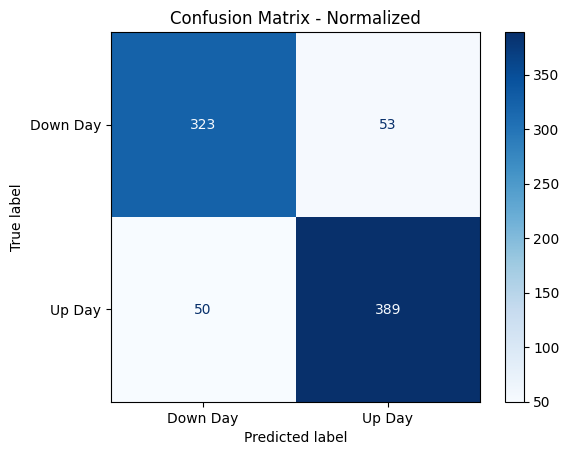

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)


# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


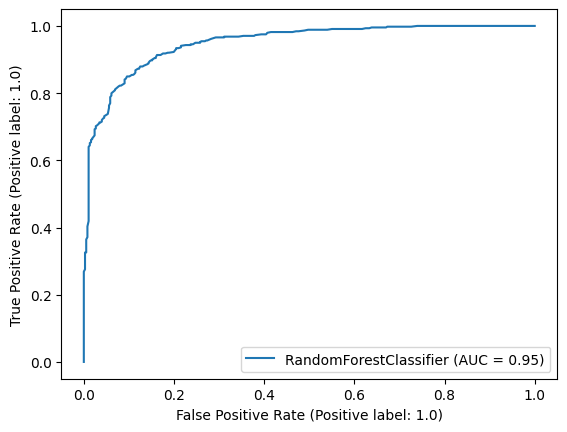

In [60]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Magalu, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para MAGALU.

In [87]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Magalu, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl']

#### Utilizando a verificação da predição com o preço real e não suavizado. Manter cross-validation.

In [61]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Magalu['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Magalu['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Magalu['Match'] = (price_data_Magalu['Prediction'] == price_data_Magalu['Verify']).astype(int)
overall_accuracy = price_data_Magalu['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Magalu[price_data_Magalu['Date'] >= price_data_Magalu['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 88.07%

Precisão do modelo nos últimos 30 dias: 80.95%


#### Plotagem:

In [263]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

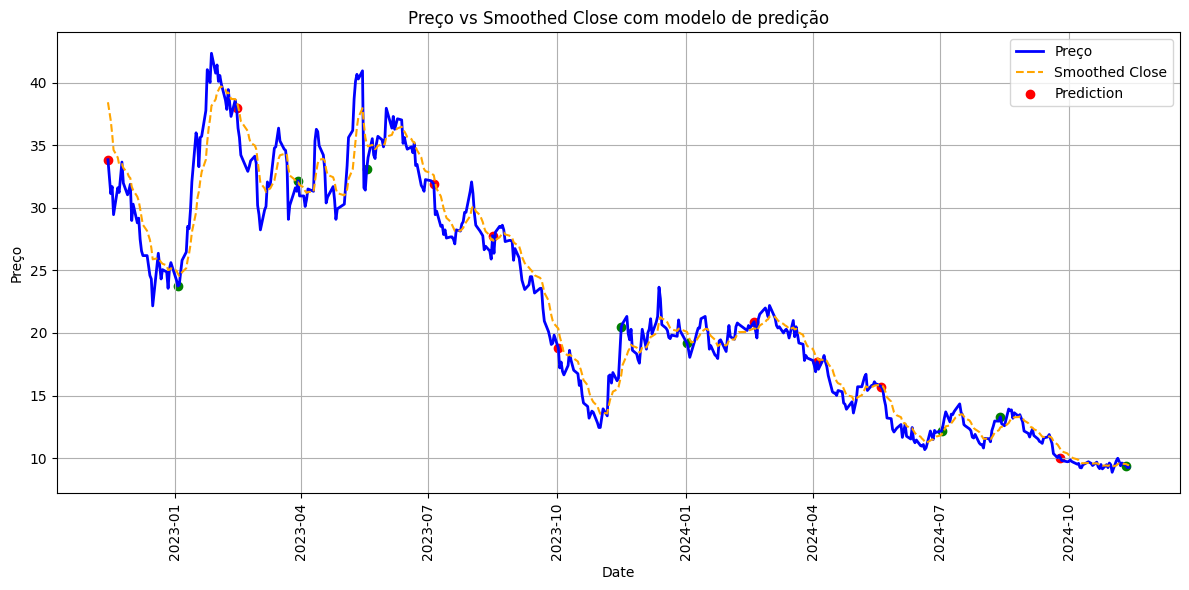

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'MGLU3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=730)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=310, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 30):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Petrobrás.

#### Time series Cross-Validation

In [63]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data_Petro.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,Close_45,Smoothed_Close_45,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
17815,2024-11-11,35.990002,36.419998,35.900002,36.250000,33.607883,21446300,PETR4.SA,0.070000,35.869957,1.0,36.250000,1.0,35.660000,37.001492,37.299999,37.104151,0.000000,0.070000,55.953060,35.029999,36.490002,57.531297,-42.468703,-0.387019,-0.343236,-0.030403,-151187174151,1
17816,2024-11-12,36.360001,37.110001,36.340000,36.930000,34.238319,39412300,PETR4.SA,0.680000,36.081966,1.0,36.930000,1.0,36.189999,36.839193,37.090000,37.101321,0.000000,0.680000,68.093498,35.029999,37.110001,50.575301,-49.424699,-0.355439,-0.345676,-0.029109,-151147761851,1
17817,2024-11-13,36.950001,37.070000,36.529999,36.880001,34.191967,34090000,PETR4.SA,-0.049999,36.241573,1.0,36.880001,-1.0,36.770000,36.825354,36.830002,37.047057,0.049999,0.000000,66.575608,35.029999,37.110001,58.248709,-41.751291,-0.313915,-0.339324,-0.031104,-151113671851,0
17818,2024-11-14,36.919998,37.330002,36.860001,37.270000,34.553543,30262100,PETR4.SA,0.389999,36.447258,1.0,37.270000,-1.0,36.380001,36.736284,36.639999,36.965646,0.000000,0.389999,72.044035,35.029999,37.330002,61.619905,-38.380095,-0.261396,-0.323739,-0.026620,-151083409751,0
17819,2024-11-18,37.200001,38.299999,37.200001,38.200001,35.415756,39004100,PETR4.SA,0.930000,36.797807,1.0,38.200001,-1.0,36.209999,36.631027,36.810001,36.934517,0.000000,0.930000,80.571363,35.029999,38.299999,54.061404,-45.938596,-0.189306,-0.296852,-0.016080,-151044405651,0


In [64]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=310, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.4466
  Accuracy with Verify: 0.4535
Fold 2:
  Accuracy with Y_test (Prediction): 0.5365
  Accuracy with Verify: 0.5295
Fold 3:
  Accuracy with Y_test (Prediction): 0.5385
  Accuracy with Verify: 0.5085
Fold 4:
  Accuracy with Y_test (Prediction): 0.5205
  Accuracy with Verify: 0.5185
Fold 5:
  Accuracy with Y_test (Prediction): 0.4605
  Accuracy with Verify: 0.4855

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5005
  Média da acurácia com Verify: 0.4991

Comparação:
      Prediction  Y_Test (Actual)  Verify
0           -1.0             -1.0    -1.0
1           -1.0              1.0    -1.0
2           -1.0              1.0    -1.0
3           -1.0             -1.0    -1.0
4           -1.0              1.0    -1.0
...          ...              ...     ...
5000        -1.0              1.0     1.0
5001        -1.0              1.0     1.0
5002        -1.0              1.0    -1.0
5003        -1.0              1.0    -

#### Walk-Forward Validation

In [65]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

In [66]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=310, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Petro) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Petro.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.3444
  Accuracy with Verify: 0.4056
Window 2:
  Accuracy with Y_test (Prediction): 0.4944
  Accuracy with Verify: 0.5167
Window 3:
  Accuracy with Y_test (Prediction): 0.1333
  Accuracy with Verify: 0.1167
Window 4:
  Accuracy with Y_test (Prediction): 0.5500
  Accuracy with Verify: 0.4667
Window 5:
  Accuracy with Y_test (Prediction): 0.4722
  Accuracy with Verify: 0.3889
Window 6:
  Accuracy with Y_test (Prediction): 0.5833
  Accuracy with Verify: 0.5500
Window 7:
  Accuracy with Y_test (Prediction): 0.6722
  Accuracy with Verify: 0.5722
Window 8:
  Accuracy with Y_test (Prediction): 0.6778
  Accuracy with Verify: 0.6611
Window 9:
  Accuracy with Y_test (Prediction): 0.4722
  Accuracy with Verify: 0.4444
Window 10:
  Accuracy with Y_test (Prediction): 0.3944
  Accuracy with Verify: 0.3667
Window 11:
  Accuracy with Y_test (Prediction): 0.6556
  Accuracy with Verify: 0.5833
Window 12:
  Accuracy with Y_test (Prediction): 0.5333
  Accura

#### Split normal sem cross-validation.

In [67]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

In [68]:
# Grab our X & Y Columns.
X_Cols = price_data_Petro[['RSI',f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators = 310, oob_score = True, criterion = "gini", random_state = 0,n_jobs=-1)

# Fit the data to the model
rand_frst_clf_Petro.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Petro.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Petro.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  80.90485695276114


In [69]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.818182,0.693419,0.750652,623.000000
Up Day,0.804103,0.890909,0.845283,880.000000
accuracy,0.809049,0.809049,0.809049,0.809049
macro avg,0.811142,0.792164,0.797967,1503.000000
weighted avg,0.809938,0.809049,0.806058,1503.000000


Accuracy: 0.8090485695276114
Precision: 0.8041025641025641
Recall: 0.8909090909090909
Specificity: 0.6934189406099518
F1-Score: 0.8453


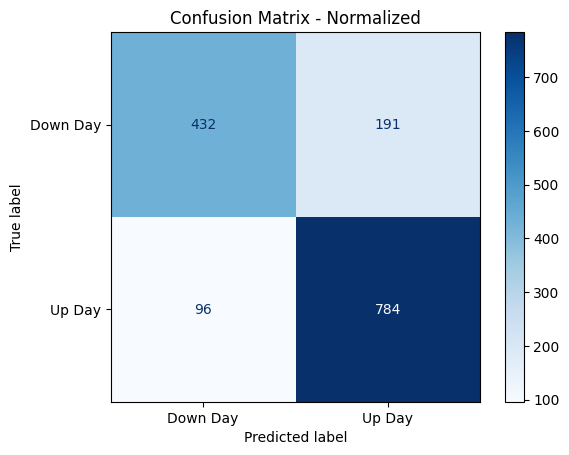

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


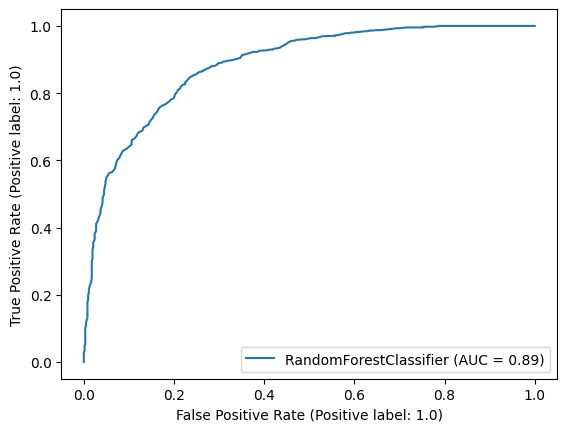

In [71]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Petro, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [100]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Petro, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [72]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Petro['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Petro['Prediction'] = rand_frst_clf_Petro.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Petro['Match'] = (price_data_Petro['Prediction'] == price_data_Petro['Verify']).astype(int)
overall_accuracy = price_data_Petro['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Petro[price_data_Petro['Date'] >= price_data_Petro['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Petro.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 81.44%

Precisão do modelo nos últimos 30 dias: 80.00%


#### Plotagem:

In [276]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

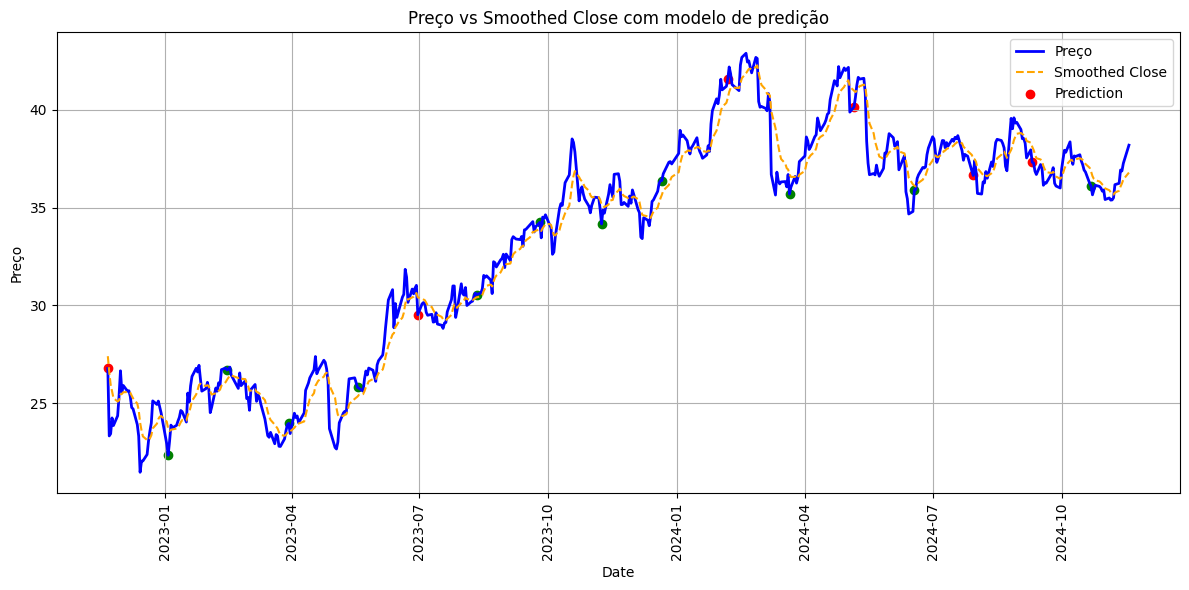

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'PETR4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=730)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=310, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 30):  
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Vale.

#### Time series Cross-Validation

In [74]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data_Vale.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,Close_45,Smoothed_Close_45,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
5778,2000-02-16,3.833333,3.833333,3.833333,3.833333,1.669120,470400,VALE3.SA,0.000000,3.902068,1.0,3.833333,-1.0,3.416666,3.303013,3.316666,3.246891,0.000000,0.000000,45.570555,3.583333,4.366666,40.689661,-59.310339,0.035860,0.045646,0.114877,18864000,0
5779,2000-02-18,3.750000,3.750000,3.750000,3.750000,1.632835,28800,VALE3.SA,-0.083333,3.871655,-1.0,3.750000,-1.0,3.330833,3.308577,3.333333,3.264180,0.083333,0.000000,41.341859,3.583333,4.366666,36.807058,-63.192942,0.028062,0.042129,0.111480,18835200,1
5780,2000-02-22,3.666666,3.666666,3.666666,3.666666,1.596549,422400,VALE3.SA,-0.083334,3.830657,-1.0,3.666666,-1.0,3.330000,3.312862,3.250000,3.261344,0.083334,0.000000,37.433943,3.583333,4.366666,31.573300,-68.426700,0.018670,0.037438,0.103936,18412800,1
5781,2000-02-24,3.750000,3.750000,3.708333,3.708333,1.614692,340800,VALE3.SA,0.041667,3.806192,-1.0,3.708333,-1.0,3.250000,3.300289,3.333333,3.275742,0.000000,0.041667,40.592709,3.583333,4.366666,28.450131,-71.549869,0.009330,0.031816,0.092373,18072000,1
5782,2000-02-25,3.666666,3.666666,3.666666,3.666666,1.596549,38400,VALE3.SA,-0.041667,3.778287,-1.0,3.666666,-1.0,3.083333,3.256898,3.233333,3.267260,0.041667,0.000000,38.411048,3.583333,4.366666,24.887758,-75.112242,-0.000130,0.025427,0.063069,18033600,1


In [75]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=310, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.6556
  Accuracy with Verify: 0.6304
Fold 2:
  Accuracy with Y_test (Prediction): 0.5478
  Accuracy with Verify: 0.4763
Fold 3:
  Accuracy with Y_test (Prediction): 0.4924
  Accuracy with Verify: 0.4632
Fold 4:
  Accuracy with Y_test (Prediction): 0.5539
  Accuracy with Verify: 0.5076
Fold 5:
  Accuracy with Y_test (Prediction): 0.5509
  Accuracy with Verify: 0.5025

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5601
  Média da acurácia com Verify: 0.5160

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2            1.0              1.0     1.0
3            1.0              1.0     1.0
4            1.0              1.0     1.0
...          ...              ...     ...
4960        -1.0             -1.0    -1.0
4961        -1.0             -1.0    -1.0
4962        -1.0             -1.0    -1.0
4963         1.0             -1.0    -

#### Walk-Forward Validation

In [76]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

In [77]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=310, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Vale) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Vale.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.5722
  Accuracy with Verify: 0.5389
Window 2:
  Accuracy with Y_test (Prediction): 0.5667
  Accuracy with Verify: 0.5167
Window 3:
  Accuracy with Y_test (Prediction): 0.4667
  Accuracy with Verify: 0.4556
Window 4:
  Accuracy with Y_test (Prediction): 0.2722
  Accuracy with Verify: 0.2333
Window 5:
  Accuracy with Y_test (Prediction): 0.8000
  Accuracy with Verify: 0.8056
Window 6:
  Accuracy with Y_test (Prediction): 0.3556
  Accuracy with Verify: 0.4222
Window 7:
  Accuracy with Y_test (Prediction): 0.4167
  Accuracy with Verify: 0.3667
Window 8:
  Accuracy with Y_test (Prediction): 0.7778
  Accuracy with Verify: 0.7278
Window 9:
  Accuracy with Y_test (Prediction): 0.6722
  Accuracy with Verify: 0.6500
Window 10:
  Accuracy with Y_test (Prediction): 0.5833
  Accuracy with Verify: 0.5000
Window 11:
  Accuracy with Y_test (Prediction): 0.4667
  Accuracy with Verify: 0.4389
Window 12:
  Accuracy with Y_test (Prediction): 0.5500
  Accura

#### Split normal sem cross-validation.

In [78]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

In [79]:
# Grab our X & Y Columns.
X_Cols = price_data_Vale[['RSI',f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators = 310, oob_score = True, criterion = "gini", random_state = 0,n_jobs=-1)

# Fit the data to the model
rand_frst_clf_Vale.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Vale.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Vale.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  80.95238095238095


In [80]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.786828,0.738211,0.761745,615.000000
Up Day,0.823851,0.859589,0.841341,876.000000
accuracy,0.809524,0.809524,0.809524,0.809524
macro avg,0.805340,0.798900,0.801543,1491.000000
weighted avg,0.808580,0.809524,0.808510,1491.000000


Accuracy: 0.8095238095238095
Precision: 0.8238512035010941
Recall: 0.8595890410958904
Specificity: 0.7382113821138211
F1-Score: 0.8413


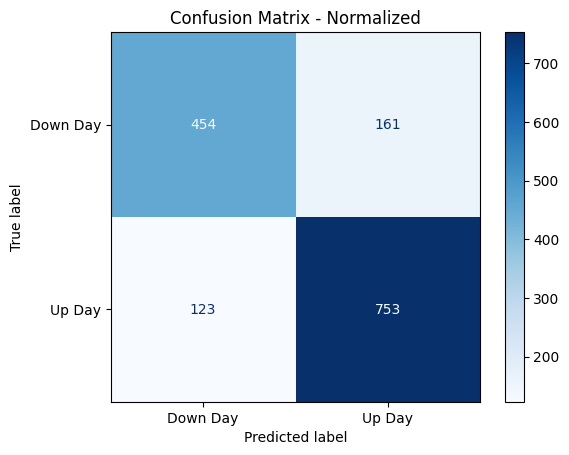

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)


# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


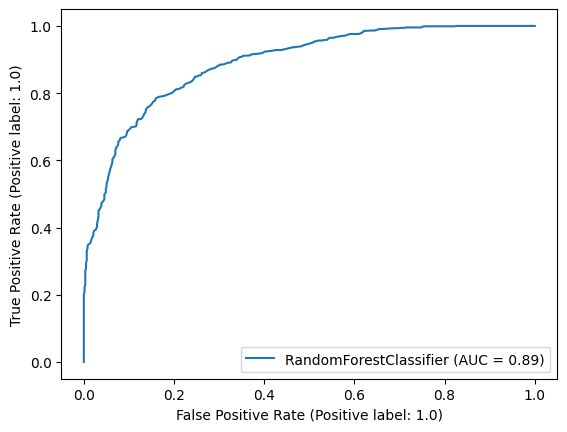

In [82]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Vale, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [113]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Vale, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [83]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Vale['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Vale['Prediction'] = rand_frst_clf_Vale.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Vale['Match'] = (price_data_Vale['Prediction'] == price_data_Vale['Verify']).astype(int)
overall_accuracy = price_data_Vale['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Vale[price_data_Vale['Date'] >= price_data_Vale['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Vale.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 83.09%

Precisão do modelo nos últimos 30 dias: 85.00%


#### Plotagem:

In [84]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

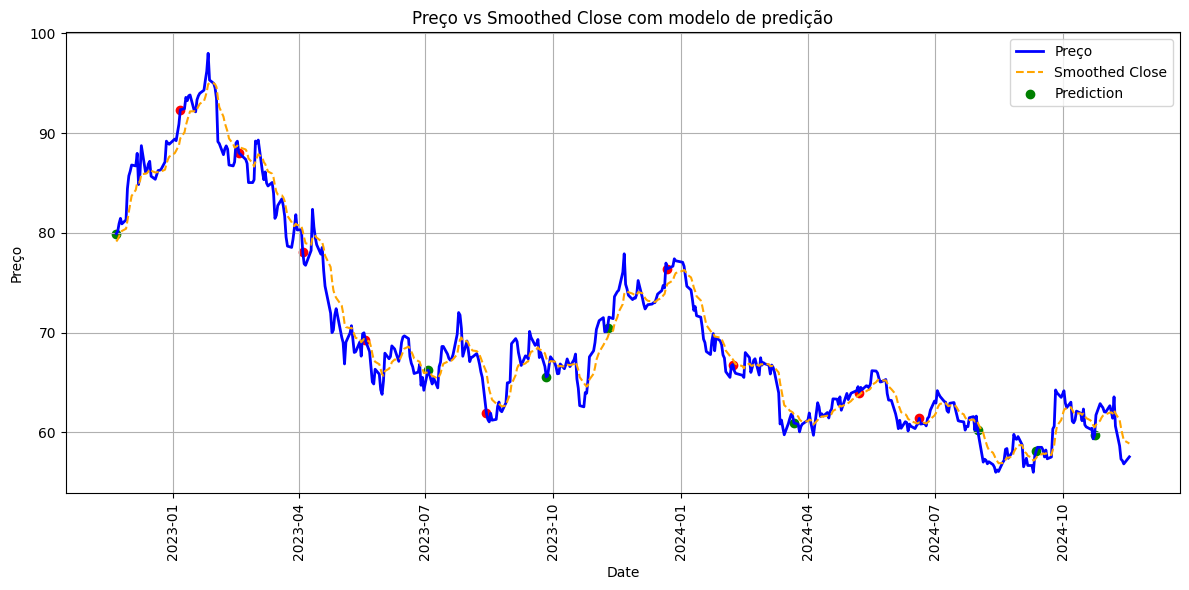

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=730)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=310, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 30):  
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()
